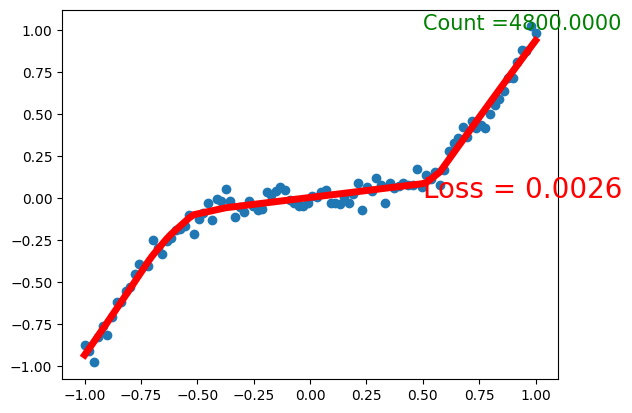

time cost 10.989996194839478 s
torch.Size([100, 1]) torch.Size([100, 1])
100


In [1]:
#导入Pytorch必须库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#绘制动态度库导入
import matplotlib.pyplot as plt
import time
from IPython import display 

time_start=time.time()
x = torch.unsqueeze(torch.linspace(-1,1,100),dim=1)
y = x.pow(3)+0.05*torch.randn(x.size())
x , y =(Variable(x),Variable(y))
torch.set_num_threads(100)  # 设置pytorch并行线程数

#模型建立
class Net(nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super(Net,self).__init__()
        self.hidden1 = nn.Linear(n_input,n_hidden)
        self.hidden2 = nn.Linear(n_hidden,n_hidden)
        self.predict = nn.Linear(n_hidden,n_output)
    def forward(self,input):
        out = self.hidden1(input)
        out = F.relu(out)#激活函数
        out = self.hidden2(out)
        out = F.sigmoid(out)#激活函数
        out =self.predict(out)
        return out

net = Net(1,20,1)
print(net)

#定义优化器和损失函数
learning_rate = 1e-1
optimizer = torch.optim.SGD(net.parameters(),lr = learning_rate)
loss_func = torch.nn.MSELoss()

#训练并绘制动态度
for t in range(5000):
    prediction = net(x)
    loss = loss_func(prediction,y)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t%200 ==0:
        plt.cla()
        display.clear_output(wait=True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss = %.4f' % loss.data, fontdict={'size': 20, 'color': 'red'})
        plt.text(0.5, 1, 'Count =%.4f' % t,fontdict={'size':15,'color':'green'})
        plt.pause(0.0002)

time_end=time.time()
print('time cost',time_end-time_start,'s')
print(x.size(),y.size())
print(torch.get_num_threads())

In [5]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models


from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#from torchvision import prototype as P

In [6]:
modelv1 = models.resnet18() 
modelv1.load_state_dict(torch.load('../models/resnet18-f37072fd.pth'))
modelv1.eval()

modelv2 = models.resnet152() 
modelv2.load_state_dict(torch.load('../models/resnet152-f82ba261.pth'))
modelv2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

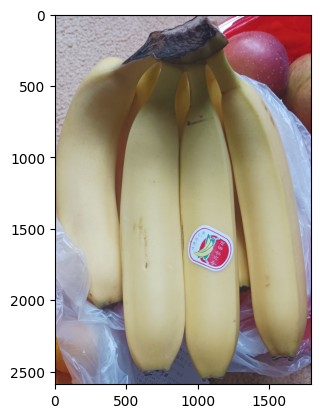

In [7]:
test_img = Image.open('../data/fzdata/banana.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()


In [9]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = '../data/fzdata/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)


In [10]:
output = modelv1(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


output = modelv2(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')




Predicted: banana ( 0.946851909160614 )
Predicted: banana ( 0.831615686416626 )


In [11]:
imgs = ['../data/fzdata/cat.jpg', 
        '../data/fzdata/flower.jpg',
        '../data/fzdata/banana.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = modelv1(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('model18:Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')
    

print("\r")
    
for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = modelv2(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('model152:Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

model18:Predicted: Egyptian_cat / 285  ( 0.10097720474004745 )
model18:Predicted: daisy / 985  ( 0.6998021602630615 )
model18:Predicted: banana / 954  ( 0.946851909160614 )

model152:Predicted: Egyptian_cat / 285  ( 0.582744300365448 )
model152:Predicted: vase / 883  ( 0.4185256361961365 )
model152:Predicted: banana / 954  ( 0.831615686416626 )
